### Random Forest Classification with Hyperparameter Tuning and SMOTE

#### Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

#### Load and Preprocess Data

In [2]:
# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop irrelevant columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)

# Convert outcome to integer type
data['outcome'] = data['outcome'].astype(int)

# Define predictor names
predictor_names = data.columns.difference(['outcome'])

#### Define Preprocessing Function

In [3]:
# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

#### Preprocess the Data

In [4]:
# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

# Define features and target variables
X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values


#### Handle Class Imbalance with SMOTE

In [5]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


#### Define and Tune the Random Forest Model

In [6]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_rf = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best hyperparameters found: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


#### Train and Evaluate the Model

In [7]:
# Train the final model with the best hyperparameters
best_rf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate the final model
y_pred_proba_final = best_rf.predict_proba(X_valid)[:, 1]
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       319
           1       0.55      0.34      0.42        35

    accuracy                           0.91       354
   macro avg       0.74      0.66      0.69       354
weighted avg       0.89      0.91      0.90       354

Final AUC: 0.8382892969099864


#### Plot ROC Curve

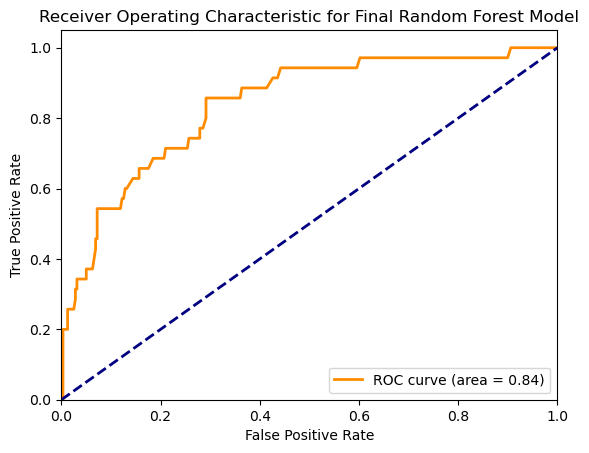

In [8]:
# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Final Random Forest Model')
plt.legend(loc="lower right")
plt.show()


#### Calculate and Plot Feature Importances

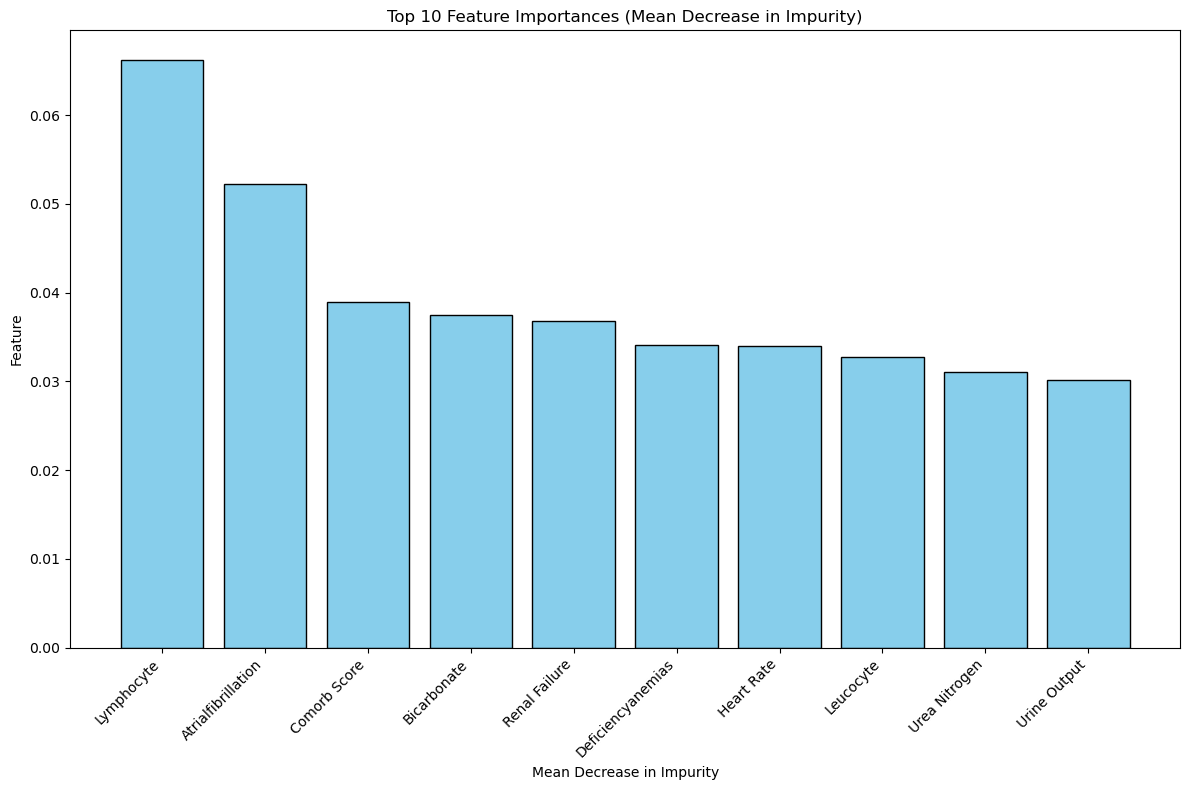

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, mi

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, mi

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, mi

In [11]:
# Calculate feature importances
feature_importances = best_rf.feature_importances_
features = predictor_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance and get the top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Modify feature names: remove underscores and capitalize the first letter of each word
top_features['Feature'] = top_features['Feature'].str.replace('_', ' ').str.title()

# Plot top 10 feature importances with updated names and spacing between the bars
plt.figure(figsize=(12, 8))
bars = plt.bar(top_features['Feature'], top_features['Importance'], color='skyblue', edgecolor='black')

# Add space between bars by adjusting the width
plt.xlabel('Mean Decrease in Impurity')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Mean Decrease in Impurity)')

# Add edge color to bars to create visual separation
for bar in bars:
    bar.set_edgecolor('black')

plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()